# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [4]:
# Check for missing values
print(portfolio.isnull().sum())

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64


In [5]:
# Convert 'channels' column to a set of dummy variables
channels = portfolio['channels'].apply(lambda x: set(x))
for channel in ['web', 'email', 'mobile', 'social']:
    portfolio[channel] = channels.apply(lambda x: 1 if channel in x else 0)


In [6]:
# Drop the original 'channels' column
portfolio = portfolio.drop('channels', axis=1)

In [7]:
# Ensure 'id' column is unique and set it as the index
if not portfolio['id'].is_unique:
    print("Warning: Non-unique values in 'id' column.")
portfolio = portfolio.set_index('id')

In [8]:
# Display the cleaned portfolio data
portfolio.head()

,difficulty,duration,offer_type,reward,web,email,mobile,social
id,,,,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,10,7,bogo,10,0,1,1,1
4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,bogo,10,1,1,1,1
3f207df678b143eea3cee63160fa8bed,0,4,informational,0,1,1,1,0
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,0
0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0


In [9]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [10]:
# Check for missing values
print(profile.isnull().sum())


age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64


In [11]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [12]:
# Convert 'became_member_on' to datetime format
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')


In [13]:
# Handle outliers or unrealistic values in 'age' and 'income'
# For example, you might replace negative age values or income values that are too high or too low with NaN
profile['age'] = profile['age'].apply(lambda x: x if 10 <= x <= 100 else None)
profile['income'] = profile['income'].apply(lambda x: x if 0 <= x <= 1e6 else None)


In [14]:
# Check for duplicate customer IDs
if profile['id'].duplicated().any():
    print("Warning: Duplicate values in 'id' column.")

In [15]:
# Set 'id' column as the index
profile = profile.set_index('id')

In [16]:
# Display the cleaned profile data
profile.head()

,age,became_member_on,gender,income
id,,,,
68be06ca386d4c31939f3a4f0e3dd783,NaN,2017-02-12,None,NaN
0610b486422d4921ae7d2bf64640c50b,55.0,2017-07-15,F,112000.0
38fe809add3b4fcf9315a9694bb96ff5,NaN,2018-07-12,None,NaN
78afa995795e4d85b5d9ceeca43f5fef,75.0,2017-05-09,F,100000.0
a03223e636434f42ac4c3df47e8bac43,NaN,2017-08-04,None,NaN


In [17]:
print(profile.isnull().sum())

age                 2180
became_member_on       0
gender              2175
income              2175
dtype: int64


In [18]:
# Check for missing values
print(transcript.isnull().sum())

event     0
person    0
time      0
value     0
dtype: int64


In [19]:
# Extract offer id and amount from the 'value' column
transcript['offer_id'] = transcript['value'].apply(lambda x: x.get('offer id') if 'offer id' in x else x.get('offer_id') if 'offer_id' in x else None)
transcript['amount'] = transcript['value'].apply(lambda x: x.get('amount') if 'amount' in x else None)


In [20]:
# Drop the original 'value' column
transcript = transcript.drop('value', axis=1)

In [21]:
# Check for duplicate records
if transcript.duplicated().any():
    print("Warning: Duplicate values in transcript data.")

In [22]:
transcript.duplicated().any()

True

In [23]:
transcript.duplicated().sum()

397

In [24]:
duplicate_rows = transcript[transcript.duplicated(keep=False)]
print("Duplicate Rows:")
print(duplicate_rows)

Duplicate Rows:
                  event                            person  time  \
66122   offer completed  3dde94fa581145cb9f206624f1a94d5a   168   
66123   offer completed  3dde94fa581145cb9f206624f1a94d5a   168   
66782   offer completed  e9fb6ed2cecb4980ba98c86abc9c91e3   168   
66783   offer completed  e9fb6ed2cecb4980ba98c86abc9c91e3   168   
67613   offer completed  a7dc060f6fc94ca7bf71fbb188187dca   168   
67614   offer completed  a7dc060f6fc94ca7bf71fbb188187dca   168   
68561   offer completed  30478a4c1e884a63a822aa87b833ed7a   168   
68562   offer completed  30478a4c1e884a63a822aa87b833ed7a   168   
69217   offer completed  84fb57a7fe8045a8bf6236738ee73a0f   168   
69218   offer completed  84fb57a7fe8045a8bf6236738ee73a0f   168   
76756   offer completed  7cd890d4d691465aa25b683943a1c056   186   
76757   offer completed  7cd890d4d691465aa25b683943a1c056   186   
79436   offer completed  1abeb816d9fa49b4b5b5ae51bc3d24c3   198   
79437   offer completed  1abeb816d9fa49b4b5b5a

In [25]:
transcript = transcript.drop_duplicates(keep='first')

In [26]:
transcript.head()

,event,person,time,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [27]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33182
Name: event, dtype: int64

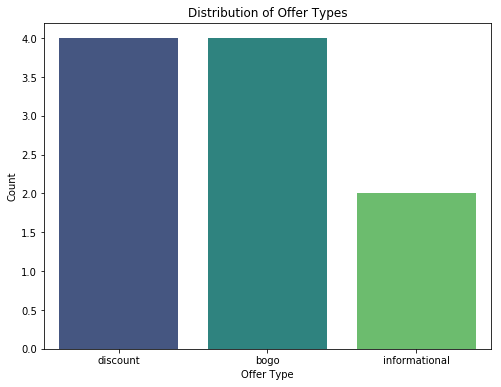

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
# Distribution of offer types
offer_type_distribution = portfolio['offer_type'].value_counts()

# Plot the distribution of offer types
plt.figure(figsize=(8, 6))
sns.barplot(x=offer_type_distribution.index, y=offer_type_distribution.values, palette='viridis')
plt.title('Distribution of Offer Types')
plt.xlabel('Offer Type')
plt.ylabel('Count')
plt.show()

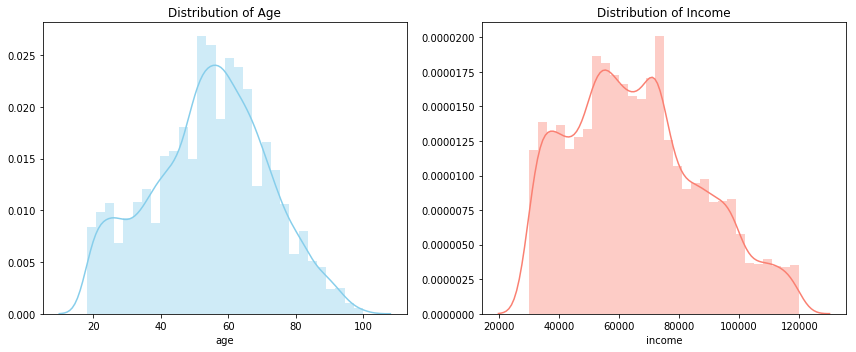

In [29]:
# Distribution of demographics (e.g., age and income)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.distplot(profile['age'].dropna(), bins=30, kde=True, color='skyblue')
plt.title('Distribution of Age')

plt.subplot(1, 2, 2)
sns.distplot(profile['income'].dropna(), bins=30, kde=True, color='salmon')
plt.title('Distribution of Income')

plt.tight_layout()
plt.show()


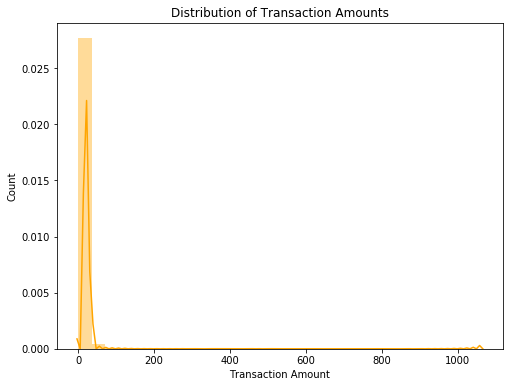

In [30]:
# Distribution of transactions
transaction_distribution = transcript[transcript['event'] == 'transaction']['amount']

plt.figure(figsize=(8, 6))
sns.distplot(transaction_distribution, bins=30, kde=True, color='orange')
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Count')
plt.show()

In [31]:
transcript.head()

,event,person,time,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [32]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33182
Name: event, dtype: int64

In [33]:
transcript.amount.isnull().sum()

167184

In [34]:
len(transcript)

306137

In [35]:
profile.head()

,age,became_member_on,gender,income
id,,,,
68be06ca386d4c31939f3a4f0e3dd783,NaN,2017-02-12,None,NaN
0610b486422d4921ae7d2bf64640c50b,55.0,2017-07-15,F,112000.0
38fe809add3b4fcf9315a9694bb96ff5,NaN,2018-07-12,None,NaN
78afa995795e4d85b5d9ceeca43f5fef,75.0,2017-05-09,F,100000.0
a03223e636434f42ac4c3df47e8bac43,NaN,2017-08-04,None,NaN


In [36]:
portfolio.head()

,difficulty,duration,offer_type,reward,web,email,mobile,social
id,,,,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,10,7,bogo,10,0,1,1,1
4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,bogo,10,1,1,1,1
3f207df678b143eea3cee63160fa8bed,0,4,informational,0,1,1,1,0
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,0
0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0


In [37]:
transcript.shape

(306137, 5)

In [38]:
# Filter rows where the event is 'offer completed'
completed_offers = transcript[transcript['event'] == 'offer completed']

# Display the top 10 rows
print("Top 10 rows where event is 'offer completed':")
print(completed_offers.head(10))

Top 10 rows where event is 'offer completed':
                 event                            person  time  \
12658  offer completed  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f     0   
12672  offer completed  fe97aa22dd3e48c8b143116a8403dd52     0   
12679  offer completed  629fc02d56414d91bca360decdfa9288     0   
12692  offer completed  676506bad68e4161b9bbaffeb039626b     0   
12697  offer completed  8f7dd3b2afe14c078eb4f6e6fe4ba97d     0   
12717  offer completed  227f2d69e46a4899b70d48182822cff6     0   
12721  offer completed  bb0f25e23a4c4de6a645527c275cd594     0   
12744  offer completed  d72d201be5794279aa716d8ad82b8d90     0   
12764  offer completed  73ffefd41e9a4ca3ab26b2b3697c6eb7     0   
12767  offer completed  3e621194f72e40d7a0b695ee9b7c38b7     0   

                               offer_id  amount  
12658  2906b810c7d4411798c6938adc9daaa5     NaN  
12672  fafdcd668e3743c1bb461111dcafc2a4     NaN  
12679  9b98b8c7a33c4b65b9aebfe6a799e6d9     NaN  
12692  ae264e3637204a6fb9bb

In [39]:
# Filter rows where the event is 'offer completed' and offer_id is not None
completed_offers_valid_ids = transcript[(transcript['event'] == 'offer completed') & (transcript['offer_id'].notna())]

# Display the rows
print("Rows where event is 'offer completed' and offer_id is not None:")
print(completed_offers_valid_ids)

Rows where event is 'offer completed' and offer_id is not None:
                  event                            person  time  \
12658   offer completed  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f     0   
12672   offer completed  fe97aa22dd3e48c8b143116a8403dd52     0   
12679   offer completed  629fc02d56414d91bca360decdfa9288     0   
12692   offer completed  676506bad68e4161b9bbaffeb039626b     0   
12697   offer completed  8f7dd3b2afe14c078eb4f6e6fe4ba97d     0   
12717   offer completed  227f2d69e46a4899b70d48182822cff6     0   
12721   offer completed  bb0f25e23a4c4de6a645527c275cd594     0   
12744   offer completed  d72d201be5794279aa716d8ad82b8d90     0   
12764   offer completed  73ffefd41e9a4ca3ab26b2b3697c6eb7     0   
12767   offer completed  3e621194f72e40d7a0b695ee9b7c38b7     0   
12780   offer completed  b860d355ef6e4c66b5d5a837c56ef32d     0   
12784   offer completed  99297ea01107436fa8c2e2bc86f55d89     0   
12786   offer completed  24115a61df25473e84a8a03f3c98de1a     0  

In [40]:

# Get unique offer IDs from transcript
transcript_offer_ids = set(transcript['offer_id'].unique())

# Get unique offer IDs from portfolio
portfolio_offer_ids = set(portfolio.index.unique())

# Find offer IDs in transcript that are not in portfolio
missing_offer_ids = transcript_offer_ids - portfolio_offer_ids

# Display the missing offer IDs
print("Offer IDs in transcript that are not in portfolio:")
print(missing_offer_ids)

Offer IDs in transcript that are not in portfolio:
{None}


In [41]:
transcript.offer_id.isnull().sum()

138953

In [42]:
transcript.shape

(306137, 5)

In [43]:
# Filter rows where the event is 'offer completed' and offer_id is None
completed_offers_null_ids = transcript[(transcript['event'] == 'offer completed') & (transcript['offer_id'].isna())]

# Display the rows
print("Rows where event is 'offer completed' and offer_id is None:")
print(completed_offers_null_ids)


Rows where event is 'offer completed' and offer_id is None:
Empty DataFrame
Columns: [event, person, time, offer_id, amount]
Index: []


In [44]:
portfolio.shape

(10, 8)

In [45]:
profile.shape

(17000, 4)

In [46]:
# Merge datasets
merged_data = transcript.merge(portfolio, how='left', left_on='offer_id', right_on='id')
merged_data = merged_data.merge(profile, how='left', left_on='person', right_on='id')


In [47]:
merged_data.shape

(306137, 17)

In [48]:
merged_data.head()

,event,person,time,offer_id,amount,difficulty,duration,offer_type,reward,web,email,mobile,social,age,became_member_on,gender,income
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0,75.0,2017-05-09,F,100000.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,20.0,10.0,discount,5.0,1.0,1.0,0.0,0.0,NaN,2017-08-04,None,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,10.0,7.0,discount,2.0,1.0,1.0,1.0,0.0,68.0,2018-04-26,M,70000.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0,NaN,2017-09-25,None,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0,NaN,2017-10-02,None,NaN


In [49]:
merged_data.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33182
Name: event, dtype: int64

In [50]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33182
Name: event, dtype: int64

In [51]:
# Check for missing values
print(merged_data.isnull().sum())

event                    0
person                   0
time                     0
offer_id            138953
amount              167184
difficulty          138953
duration            138953
offer_type          138953
reward              138953
web                 138953
email               138953
mobile              138953
social              138953
age                  33847
became_member_on         0
gender               33749
income               33749
dtype: int64


In [52]:
merged_data = merged_data.drop(['amount'], axis=1)

In [53]:
merged_data.dropna(inplace=True)

In [54]:
merged_data.shape

(148380, 16)

In [55]:
# Check for missing values
print(merged_data.isnull().sum())

event               0
person              0
time                0
offer_id            0
difficulty          0
duration            0
offer_type          0
reward              0
web                 0
email               0
mobile              0
social              0
age                 0
became_member_on    0
gender              0
income              0
dtype: int64


In [56]:
# Filter for completed offers only

completed_offers = merged_data[merged_data['event'] == 'offer completed']

In [57]:
completed_offers.shape

(32058, 16)

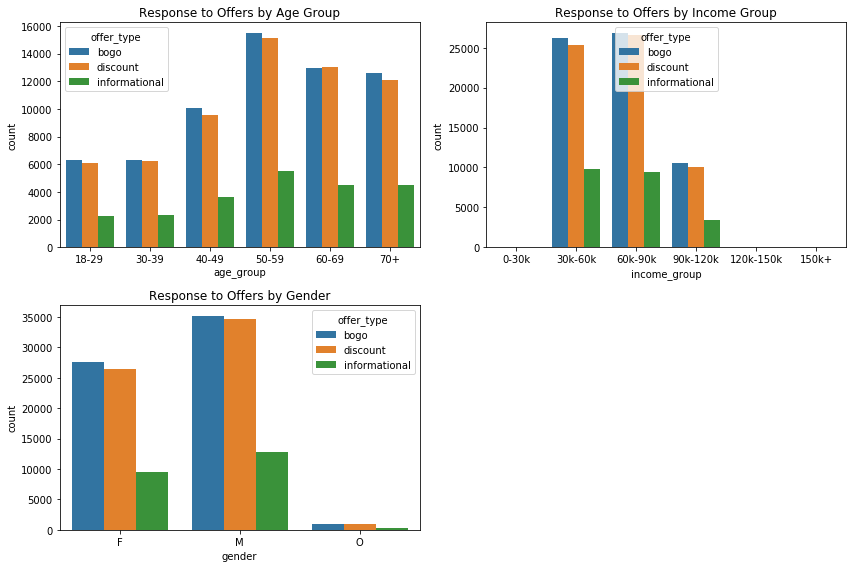

In [58]:


# Create age groups
bins = [18, 30, 40, 50, 60, 70, 120]
labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70+']
merged_data['age_group'] = pd.cut(merged_data['age'].fillna(-1), bins=bins, labels=labels, right=False)

# Filter out rows where age is missing or set to -1
completed_offers = merged_data[merged_data['age_group'] != -1]

# Create income groups
bins = [0, 30000, 60000, 90000, 120000, 150000, float('inf')]
labels = ['0-30k', '30k-60k', '60k-90k', '90k-120k', '120k-150k', '150k+']
merged_data['income_group'] = pd.cut(merged_data['income'].fillna(-1), bins=bins, labels=labels, right=False)

# Filter out rows where income is missing or set to -1
completed_offers = merged_data[merged_data['income_group'] != -1]


# Analyze response to each offer type by demographic group
plt.figure(figsize=(12, 8))

# Response by age group
plt.subplot(2, 2, 1)
sns.countplot(x='age_group', hue='offer_type', data=completed_offers)
plt.title('Response to Offers by Age Group')

# Response by income group
plt.subplot(2, 2, 2)
sns.countplot(x='income_group', hue='offer_type', data=completed_offers)
plt.title('Response to Offers by Income Group')

# Response by gender
plt.subplot(2, 2, 3)
sns.countplot(x='gender', hue='offer_type', data=completed_offers)
plt.title('Response to Offers by Gender')

plt.tight_layout()
plt.show()


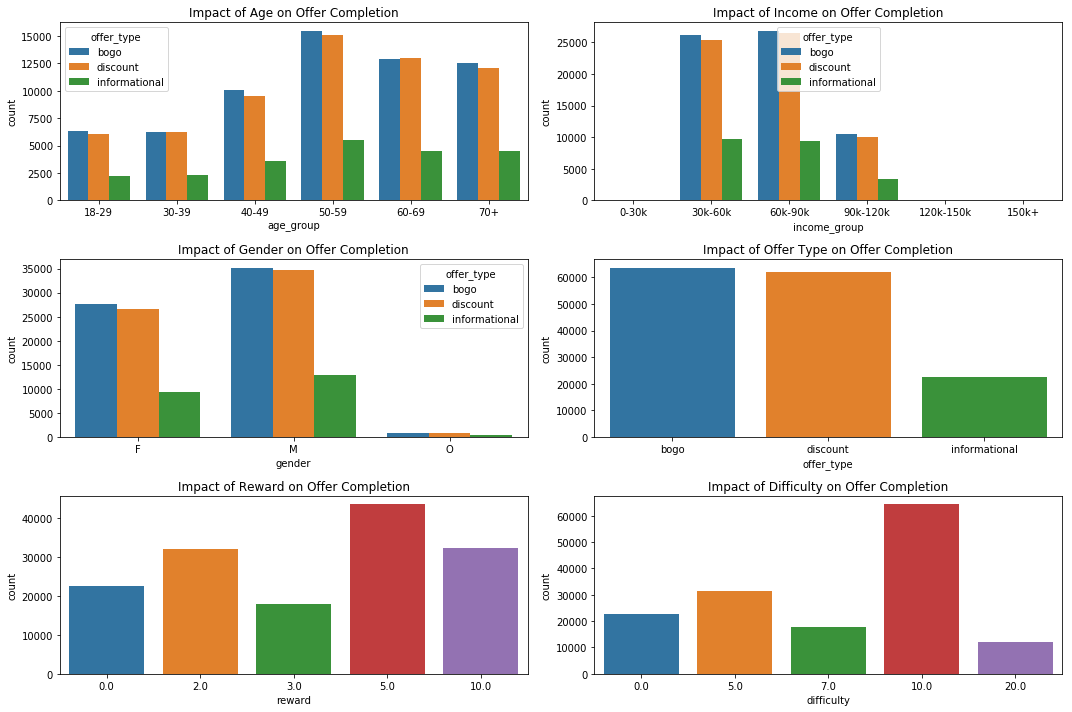

In [59]:
# Explore impact based on different factors
plt.figure(figsize=(15, 10))

# Impact of age on offer completion
plt.subplot(3, 2, 1)
sns.countplot(x='age_group', hue='offer_type', data=completed_offers)
plt.title('Impact of Age on Offer Completion')

# Impact of income on offer completion
plt.subplot(3, 2, 2)
sns.countplot(x='income_group', hue='offer_type', data=completed_offers)
plt.title('Impact of Income on Offer Completion')

# Impact of gender on offer completion
plt.subplot(3, 2, 3)
sns.countplot(x='gender', hue='offer_type', data=completed_offers)
plt.title('Impact of Gender on Offer Completion')

# Impact of offer type on offer completion
plt.subplot(3, 2, 4)
sns.countplot(x='offer_type', data=completed_offers)
plt.title('Impact of Offer Type on Offer Completion')

# Impact of reward on offer completion
plt.subplot(3, 2, 5)
sns.countplot(x='reward', data=completed_offers)
plt.title('Impact of Reward on Offer Completion')

# Impact of difficulty on offer completion
plt.subplot(3, 2, 6)
sns.countplot(x='difficulty', data=completed_offers)
plt.title('Impact of Difficulty on Offer Completion')

plt.tight_layout()
plt.show()

In [60]:
merged_data.columns

Index(['event', 'person', 'time', 'offer_id', 'difficulty', 'duration',
       'offer_type', 'reward', 'web', 'email', 'mobile', 'social', 'age',
       'became_member_on', 'gender', 'income', 'age_group', 'income_group'],
      dtype='object')

In [61]:
merged_data.dtypes

event                       object
person                      object
time                         int64
offer_id                    object
difficulty                 float64
duration                   float64
offer_type                  object
reward                     float64
web                        float64
email                      float64
mobile                     float64
social                     float64
age                        float64
became_member_on    datetime64[ns]
gender                      object
income                     float64
age_group                 category
income_group              category
dtype: object

In [62]:
merged_data.event.value_counts()

offer received     66478
offer viewed       49844
offer completed    32058
Name: event, dtype: int64

In [63]:
merged_data.head()

,event,person,time,offer_id,difficulty,duration,offer_type,reward,web,email,mobile,social,age,became_member_on,gender,income,age_group,income_group
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0,75.0,2017-05-09,F,100000.0,70+,90k-120k
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,10.0,7.0,discount,2.0,1.0,1.0,1.0,0.0,68.0,2018-04-26,M,70000.0,60-69,60k-90k
5,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0,65.0,2018-02-09,M,53000.0,60-69,30k-60k
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,0.0,4.0,informational,0.0,1.0,1.0,1.0,0.0,58.0,2017-11-11,M,51000.0,50-59,30k-60k
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,20.0,10.0,discount,5.0,1.0,1.0,0.0,0.0,61.0,2017-09-11,F,57000.0,60-69,30k-60k


In [64]:
# Apply one-hot encoding to the 'gender' column
merged_data = pd.get_dummies(merged_data, columns=['gender','offer_type'])


In [65]:
merged_data.head()

,event,person,time,offer_id,difficulty,duration,reward,web,email,mobile,...,became_member_on,income,age_group,income_group,gender_F,gender_M,gender_O,offer_type_bogo,offer_type_discount,offer_type_informational
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,7.0,5.0,1.0,1.0,1.0,...,2017-05-09,100000.0,70+,90k-120k,1,0,0,1,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,10.0,7.0,2.0,1.0,1.0,1.0,...,2018-04-26,70000.0,60-69,60k-90k,0,1,0,0,1,0
5,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,1.0,1.0,1.0,...,2018-02-09,53000.0,60-69,30k-60k,0,1,0,1,0,0
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,0.0,4.0,0.0,1.0,1.0,1.0,...,2017-11-11,51000.0,50-59,30k-60k,0,1,0,0,0,1
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,20.0,10.0,5.0,1.0,1.0,0.0,...,2017-09-11,57000.0,60-69,30k-60k,1,0,0,0,1,0


In [66]:
merged_data.dtypes

event                               object
person                              object
time                                 int64
offer_id                            object
difficulty                         float64
duration                           float64
reward                             float64
web                                float64
email                              float64
mobile                             float64
social                             float64
age                                float64
became_member_on            datetime64[ns]
income                             float64
age_group                         category
income_group                      category
gender_F                             uint8
gender_M                             uint8
gender_O                             uint8
offer_type_bogo                      uint8
offer_type_discount                  uint8
offer_type_informational             uint8
dtype: object

In [67]:
merged_data.isnull().sum()

event                       0
person                      0
time                        0
offer_id                    0
difficulty                  0
duration                    0
reward                      0
web                         0
email                       0
mobile                      0
social                      0
age                         0
became_member_on            0
income                      0
age_group                   0
income_group                0
gender_F                    0
gender_M                    0
gender_O                    0
offer_type_bogo             0
offer_type_discount         0
offer_type_informational    0
dtype: int64

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Define features and target variable
features = ['difficulty', 'duration', 'reward', 'web', 'email', 'mobile', 'social', 'age', 'income', 'gender_F', 'gender_M', 'gender_O', 'offer_type_bogo', 'offer_type_discount', 'offer_type_informational']
target = 'event'  # Assuming 'event' is the target variable

# Create a binary target variable indicating offer success
merged_data['offer_success'] = (merged_data['event'] == 'offer completed').astype(int)

# Separate numerical and categorical features
numeric_features = ['difficulty', 'duration', 'reward', 'age', 'income']




In [69]:
# Select features and target variable
X = merged_data[features]
y = merged_data['offer_success']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create and train a RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

# Display evaluation metrics
print(f'Accuracy: {accuracy:.2f}')
print('\nClassification Report:')
print(classification_rep)
print('\nConfusion Matrix:')
print(confusion_mat)

Accuracy: 0.67

Classification Report:
             precision    recall  f1-score   support

          0       0.76      0.85      0.80     23264
          1       0.03      0.01      0.02      6412

avg / total       0.60      0.67      0.63     29676


Confusion Matrix:
[[19774  3490]
 [ 6322    90]]


In [70]:
merged_data.event.value_counts()

offer received     66478
offer viewed       49844
offer completed    32058
Name: event, dtype: int64

In [71]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33182
Name: event, dtype: int64

In [72]:
merged_data['offer_success'].value_counts()

0    116322
1     32058
Name: offer_success, dtype: int64

In [73]:
# Print feature importance
feature_importance = model.feature_importances_
print("Feature Importance:")
for feature, importance in zip(features, feature_importance):
    print(f"{feature}: {importance:.4f}")

Feature Importance:
difficulty: 0.0199
duration: 0.0293
reward: 0.0491
web: 0.0039
email: 0.0000
mobile: 0.0002
social: 0.0027
age: 0.4617
income: 0.3900
gender_F: 0.0054
gender_M: 0.0025
gender_O: 0.0008
offer_type_bogo: 0.0097
offer_type_discount: 0.0095
offer_type_informational: 0.0153
